<a href="https://colab.research.google.com/github/ross-hugo/Artwork-GAN/blob/main/notebooks/Working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Uncomment if runninng on google colab, comment otherwise
!git clone https://github.com/ross-hugo/Artwork-GAN/
%cd Artwork-GAN/

Cloning into 'Artwork-GAN'...
remote: Enumerating objects: 8289, done.
remote: Counting objects: 100% (8289/8289), done.
remote: Compressing objects: 100% (8260/8260), done.
remote: Total 8289 (delta 46), reused 8248 (delta 23), pack-reused 0
Receiving objects: 100% (8289/8289), 91.94 MiB | 32.76 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/Artwork-GAN


In [2]:
# Uncomment if running locally, comment otherwise
# import os
# os.chdir("..")
# os.getcwd()

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

import os

# Keras functions
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten
from tensorflow.keras.layers import Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D, UpSampling2D
from tensorflow.keras.layers import Input, Reshape
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.backend import mean
from math import pi
# Numpy functions
import numpy
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import zeros
from numpy import ones
from numpy import asarray

from PIL import Image

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [4]:
WIDTH = 128
HEIGHT = 128
IMG_SIZE = (WIDTH,HEIGHT)
SEED_SIZE = 100
IMAGE_CHANNELS = 3
EPOCHS = 20
noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE=128

In [5]:
class Generator():
  def __init__(self):
    self.model = None
    self.opt = Adam(0.0002,0.5)

  def define_generator_model(self):
    model = tf.keras.Sequential()
    
    model.add(Dense(4*4*512,activation="relu",input_dim=100))
    model.add(Reshape((4,4,512)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))

    model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dropout(0.4))

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha =0.3))
    model.add(Dropout(0.4))
    
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False  ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))
    
    model.add(Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False  ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))
    
    model.add(Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False  ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=True, activation='tanh'))
    noise = Input(shape=(100,))
    img = model(noise)

    self.model = Model(noise, img)
    return Model(noise, img)

  def generator_loss(self,fake_output):
    cross_entropy = BinaryCrossentropy()
    return cross_entropy(tf.ones_like(fake_output), fake_output)
  
  def generator_opt(self):
    return self.opt

In [6]:
class Discriminator():
  def __init__(self):
    self.model = None
    self.image_shape = (128,128,3)
    self.opt = Adam(0.0002,0.5)
  def define_discriminator_model(self):
    model = tf.keras.Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))


    #block2
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))

    #block3
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2,  padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))

    #block4
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))

    #add ReLU layer
    model.add(LeakyReLU(alpha=0.2))
    
    img = Input(shape=(128, 128, 3))
    features = model(img)
    valid = Dense(1, activation="sigmoid")(features)
    label = Dense(5, activation="softmax")(features)

    self.model = Model(img, [valid, label])
    return Model(img, [valid, label])

  def discriminator_loss(self,real_output, fake_output):
    cross_entropy = BinaryCrossentropy()
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss 
  
  def discriminator_opt(self):
    return self.opt
  
  def discriminator_accuracy(self, real_output, fake_output):
    real_acc = mean(binary_accuracy(tf.ones_like(real_output), real_output))
    fake_acc = mean(binary_accuracy(tf.zeros_like(fake_output), fake_output))

    return real_acc, fake_acc


In [7]:
generator = Generator().define_generator_model()
discriminator = Discriminator().define_discriminator_model()

[<tf.Tensor: shape=(1, 1, 1, 1), dtype=float32, numpy=array([[[[0.50000024]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 5), dtype=float32, numpy=
array([[[[0.19999984, 0.19999878, 0.19999793, 0.20000248, 0.20000099]]]],
      dtype=float32)>]


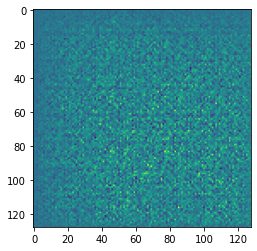

In [8]:
noise = tf.random.normal([1,SEED_SIZE])

generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

image_shape = (HEIGHT, HEIGHT, IMAGE_CHANNELS)

print(discriminator(generated_image))


In [9]:
def generate_images(generated_images2):
    fig = plt.figure(figsize=(10,10))
    for i in range(1,21):
        fig.add_subplot(5,5,i)
        plt.imshow(generated_images2[i])
        plt.axis('off')
    plt.show()

In [10]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [11]:
from src.utils import image_dataset_from_directory
dir = "images/"

  # labels="inferred", label_mode="int"
train_ds = image_dataset_from_directory(dir,
  seed=123,
  label_mode=None
  ,image_size=(128, 128), color_mode= "rgb",
  batch_size=BATCH_SIZE)

Found 8118 files belonging to 49 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [12]:
def process(image):
  image = tf.cast((image -127.5)/127.5 ,tf.float32)
  return image

train_ds = train_ds.map(process)
train_ds

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


<MapDataset shapes: (None, 128, 128, 3), types: tf.float32>

In [13]:
# https://keras.io/guides/writing_a_training_loop_from_scratch/
class GAN():
  def __init__(self):
    the_disc = Discriminator()
    the_gen = Generator()

    self.generator = the_gen.define_generator_model()
    self.generator_optimizer = the_gen.generator_opt()
    self.generator_losses = []

    self.discriminator = the_disc.define_discriminator_model()
    self.discriminator_optimizer = the_disc.discriminator_opt()
    self.discriminator_losses = []

    noise = Input(shape=(100,))
    img = self.generator(noise)
    valid, _ = self.discriminator(img)
    self.combined = Model(noise, valid)
    self.combined_opt = Adam(0.0002, 0.5)
    self.combined.compile(loss=['binary_crossentropy'], optimizer=self.combined_opt)

    self.accuracy = []

  @tf.function
  def train_step(self, images, batch_size):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      images_90 = tf.image.rot90(images, k=1)
      images_180 = tf.image.rot90(images, k=2)
      images_270 = tf.image.rot90(images, k=3)
      
      combined_images = tf.concat([images, images_90, images_180, images_270], axis=0)

      generated_images = self.generator(noise, training=True)
      real_output, _  = self.discriminator(combined_images, training=True)
      fake_output, _  = self.discriminator(generated_images, training=True)
      
      gen_loss = Generator().generator_loss(fake_output)
      disc_loss = Discriminator().discriminator_loss(real_output, fake_output)
      
      real_acc, fake_acc = Discriminator().discriminator_accuracy(real_output, fake_output)

    real_acc, fake_acc = Discriminator().discriminator_accuracy(real_output, fake_output)
  
    gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
    
    self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
    self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

    return gen_loss , disc_loss , generated_images, real_acc, fake_acc

  def train(self, epochs, batch_size, X=None, y=None, display_iter=10):
    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []
        start = time.time()

        for image_batch in (X):
            t =  self.train_step(image_batch, batch_size)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])
        
        g_loss = sum(gen_loss_list) / len(gen_loss_list) #calculate losses
        d_loss = sum(disc_loss_list) / len(disc_loss_list)
        
        acc = (t[3] + t[4]) * 0.5
        self.accuracy.append(acc)

        generate_images(t[2])
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
        print(f'Epoch {epoch+1}, gen loss = {g_loss}, disc loss = {d_loss},acc = {acc}')
        self.generator_losses.append(g_loss)
        self.discriminator_losses.append(d_loss)

    
  # Generate after the final epoch
  display.clear_output(wait=True)

In [14]:
gan = GAN()

In [15]:
gan.generator = load_model('trained_models' + '/generator.h5')
gan.discriminator = load_model('trained_models' + '/discriminator.h5')
gan.combined = load_model('trained_models' + '/combined.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

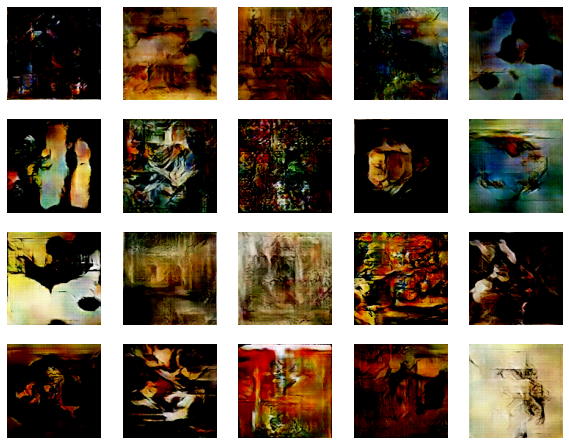

Time for epoch 1 is 1240.602070093155 sec
Epoch 1, gen loss = 7.9132280349731445, disc loss = 0.18146756291389465,acc = 0.9820601940155029


In [ ]:
gan.train(X=train_ds, y=train_ds, epochs=EPOCHS, batch_size=BATCH_SIZE, display_iter=2)


In [ ]:
gan.generator.save('trained_models/generator.h5')
gan.discriminator.save('trained_models/discriminator.h5')
gan.combined.save('trained_models/combined.h5')

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.plot(range(EPOCHS) ,gan.generator_losses, label="Generator Loss")
plt.plot(range(EPOCHS) ,gan.discriminator_losses, label="Discriminator Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.plot(range(EPOCHS) ,gan.accuracy, label="Accuracy")
plt.show()